<a href="https://colab.research.google.com/github/dvschultz/ShapeMatchingGAN/blob/master/ShapeMatchingGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shape Matching GAN

# Install Library and required data

In [1]:
!git clone https://github.com/dvschultz/ShapeMatchingGAN
%cd ShapeMatchingGAN/save
!gdown --id 1gjHR39deUSPChtRbKAD80waoQFTiXyMs #download example checkpoint files
!unzip ShapeMGAN-data_plus_model.zip
!rm -r data/style
!mkdir ../data/rawtext/yaheiB/train
!mv data/rawtext/yaheiB/train/*.* ../data/rawtext/yaheiB/train/
!mkdir ../data/rawtext/augment
!mv data/rawtext/augment/*.* ../data/rawtext/augment/
!mv save/*.* ./
!rmdir save
!rm ShapeMGAN-data_plus_model.zip
!rm -r data
%cd ../src

Cloning into 'ShapeMatchingGAN'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 615 (delta 10), reused 2 (delta 0), pack-reused 592
Receiving objects: 100% (615/615), 6.23 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (291/291), done.
/content/ShapeMatchingGAN/save
Downloading...
From: https://drive.google.com/uc?id=1gjHR39deUSPChtRbKAD80waoQFTiXyMs
To: /content/ShapeMatchingGAN/save/ShapeMGAN-data_plus_model.zip
118MB [00:00, 192MB/s]
Archive:  ShapeMGAN-data_plus_model.zip
   creating: data/
   creating: data/rawtext/
   creating: data/rawtext/augment/
  inflating: data/rawtext/augment/0000.png  
  inflating: data/rawtext/augment/0001.png  
  inflating: data/rawtext/augment/0002.png  
  inflating: data/rawtext/augment/0003.png  
  inflating: data/rawtext/augment/0004.png  
   creating: data/rawtext/yaheiB/
   creating: data/rawtext/yaheiB/train/
  inflating: data/rawtext/yaheiB/tra

# Test
Let’s run a sample test to see how it does. This will generate a file named 'output.png' in your `/output/` folder.

In [9]:
!python test.py --scale 0.0 --structure_model ../save/fire-GS-iccv.ckpt --texture_model ../save/fire-GT-iccv.ckpt --gpu

--- load options ---
gpu: True
name: output
result_dir: ../output/
scale: 0.0
scale_step: 0.2
structure_model: ../save/fire-GS-iccv.ckpt
text_name: ../data/rawtext/yaheiB/val/0801.png
text_type: 0
texture_model: ../save/fire-GT-iccv.ckpt
--- load data ---
--- load model ---
--- testing ---
--- save ---


Another example with some additional arguments. This will generate multiple images at different “scales.” It will produce something like an animation when all the frames are combined.

In [5]:
!python test.py --text_name ../data/rawtext/yaheiB/val/0801.png --scale -1 --scale_step 0.005 --structure_model ../save/fire-GS-iccv.ckpt --texture_model ../save/fire-GT-iccv.ckpt --result_dir ../output --name fire-0801 --gpu

--- load options ---
gpu: True
name: ladiescrop-0801
result_dir: ../output
scale: -1.0
scale_step: 0.005
structure_model: /content/ShapeMatchingGAN/save/ladiescrop-GS.ckpt
text_name: ../data/rawtext/yaheiB/val/0801.png
text_type: 0
texture_model: /content/ShapeMatchingGAN/save/ladiescrop-GT.ckpt
--- load data ---
--- load model ---
--- testing ---
--- save ---


We can zip all of these images up and download them. Once finished, in the Files tab on the left you’ll see a file named `fire_images.zip` Control-click on it and select `Download`.

In [6]:
!zip /content/fire_images.zip /content/ShapeMatchingGAN/output/fire-0801_*.png

  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_0.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_100.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_101.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_102.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_103.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_104.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_105.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_106.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_107.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_108.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_109.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/ladiescrop-0801_10.png (deflated 0%)
  adding: content/ShapeMatchingGAN/output/l

# Train a custom model
Training a custom model happens in 3 different training parts. From what I can tell you don’t need to train the Sketch Module—the pretrained model is fine.

## Image Pre-processing
To train a custom model you need to process your image in the format SMGAN requires. I’ll be documenting this better shortly.

**TODO:** make this all one operation using OpenCV.


<PIL.Image.Image image mode=RGB size=768x1280 at 0x7F8AC82C7C88>


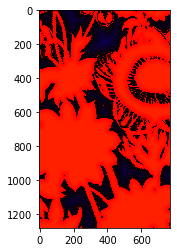

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import cv2
import scipy.ndimage as pyimg
import random
import os

import utils

# netShapeM.G_S.load_state_dict(torch.load('content/ShapeMatchingGAN/save/maple-GS-iccv.ckpt'))  
# netShapeM.eval()
I = utils.text_image_preprocessing('/content/uploads/ladiescrop.png')
print(I)
os.chdir('/content/outputs/')
cv2.imwrite('ladiescrop.png', cv2.cvtColor(np.array(I),cv2.COLOR_RGB2BGR))
plt.imshow(I)

## Train the Sketch Module (optional)
The Sketch Module is trained on the letter shapes. Unless you have a specific need you can use the pre-trained model for this.

In [2]:
# !python trainSketchModule.py --help
!python trainSketchModule.py --text_path ../data/rawtext/yaheiB/train --text_datasize 708 --augment_text_path ../data/rawtext/augment --augment_text_datasize 5 --batchsize 16 --Btraining_num 12800 --save_GB_name ../save/GB.ckpt --gpu

--- load options ---
Btraining_num: 12800
DB_nf: 32
DB_nlayers: 5
GB_nf: 32
GB_nlayers: 6
augment_text_datasize: 5
augment_text_path: ../data/rawtext/augment
batchsize: 16
epochs: 3
gpu: True
save_GB_name: ../save/GB.ckpt
text_datasize: 708
text_path: ../data/rawtext/yaheiB/train
--- create model ---
--- training ---
Epoch [1/3][001/800]: LDadv: +0.017, LGadv: +0.152, Lrec: +81.663
Epoch [1/3][002/800]: LDadv: +0.061, LGadv: +0.158, Lrec: +63.030
Epoch [1/3][003/800]: LDadv: +0.086, LGadv: +0.158, Lrec: +49.606
Epoch [1/3][004/800]: LDadv: +0.069, LGadv: +0.152, Lrec: +36.851
Epoch [1/3][005/800]: LDadv: +0.078, LGadv: +0.175, Lrec: +26.935
Epoch [1/3][006/800]: LDadv: +0.057, LGadv: +0.174, Lrec: +22.889
Epoch [1/3][007/800]: LDadv: +0.049, LGadv: +0.147, Lrec: +18.177
Epoch [1/3][008/800]: LDadv: +0.037, LGadv: +0.146, Lrec: +17.177
Epoch [1/3][009/800]: LDadv: +0.022, LGadv: +0.173, Lrec: +15.270
Epoch [1/3][010/800]: LDadv: +0.025, LGadv: +0.158, Lrec: +13.684
Epoch [1/3][011/800]:

## Train the Structure Transfer model

The Structure Transfer model will take the most time to train—usually it takes a few hours to train. 

When completed there will be two new models in the `/save` folder. One is labeled {name}-GS.ckpt and the other {name}-DS.ckpt. You should download the GS as soon as its done—you don’t need the DS checkpoint unless you want to resume training at a later date.

In [3]:
!python trainStructureTransfer.py --style_name ../data/style/ladiescrop-720.png --batchsize 16 --Straining_num 2560 --step1_epochs 30 --step2_epochs 40 --step3_epochs 80 --scale_num 4 --Sanglejitter --save_path ../save --save_name ladiescrop --gpu

Streaming output truncated to the last 5000 lines.
Step3, Epoch [49/80][123/160]: LDadv: +0.271, LGadv: +4.306, Lrec: +1.545, Lgly: +0.000
Step3, Epoch [49/80][124/160]: LDadv: +0.215, LGadv: +4.202, Lrec: +1.440, Lgly: +0.000
Step3, Epoch [49/80][125/160]: LDadv: +0.157, LGadv: +4.277, Lrec: +1.308, Lgly: +0.000
Step3, Epoch [49/80][126/160]: LDadv: +0.190, LGadv: +4.228, Lrec: +1.709, Lgly: +0.000
Step3, Epoch [49/80][127/160]: LDadv: +0.108, LGadv: +4.460, Lrec: +1.320, Lgly: +0.000
Step3, Epoch [49/80][128/160]: LDadv: +0.126, LGadv: +4.156, Lrec: +1.263, Lgly: +0.000
Step3, Epoch [49/80][129/160]: LDadv: +0.129, LGadv: +4.168, Lrec: +1.372, Lgly: +0.000
Step3, Epoch [49/80][130/160]: LDadv: +0.214, LGadv: +4.197, Lrec: +1.550, Lgly: +0.000
Step3, Epoch [49/80][131/160]: LDadv: +0.209, LGadv: +4.565, Lrec: +1.263, Lgly: +0.000
Step3, Epoch [49/80][132/160]: LDadv: +0.129, LGadv: +4.411, Lrec: +1.202, Lgly: +0.000
Step3, Epoch [49/80][133/160]: LDadv: +0.169, LGadv: +4.069, Lrec: +1

## Train the Texture Transfer
The Texture Transfer model will take the some time to train, but is much faster than the Structure model. It usually takes me ~hour or so. 

When completed there will be two new models in the `/save` folder. One is labeled {name}-GT.ckpt and the other {name}-DT.ckpt. You should download the GT as soon as its done—you don’t need the DT checkpoint unless you want to resume training at a later date.

In [4]:
!python trainTextureTransfer.py --style_name ../data/style/ladiescrop-720.png --batchsize 4 --Ttraining_num 800 --texture_step1_epochs 40 --Tanglejitter --save_path ../save --save_name ladiescrop --gpu

Streaming output truncated to the last 5000 lines.
Step1, Epoch [16/40][003/200]: LDadv: +1.254, LGadv: +6.671, Lrec: +12.390, Lsty: +0.000
Step1, Epoch [16/40][004/200]: LDadv: +2.278, LGadv: +6.972, Lrec: +12.553, Lsty: +0.000
Step1, Epoch [16/40][005/200]: LDadv: +1.560, LGadv: +7.102, Lrec: +12.353, Lsty: +0.000
Step1, Epoch [16/40][006/200]: LDadv: +1.402, LGadv: +5.701, Lrec: +13.199, Lsty: +0.000
Step1, Epoch [16/40][007/200]: LDadv: +1.864, LGadv: +3.788, Lrec: +12.633, Lsty: +0.000
Step1, Epoch [16/40][008/200]: LDadv: +1.426, LGadv: +4.095, Lrec: +13.115, Lsty: +0.000
Step1, Epoch [16/40][009/200]: LDadv: +3.194, LGadv: +6.253, Lrec: +12.861, Lsty: +0.000
Step1, Epoch [16/40][010/200]: LDadv: +1.980, LGadv: +5.056, Lrec: +13.538, Lsty: +0.000
Step1, Epoch [16/40][011/200]: LDadv: +1.644, LGadv: +7.520, Lrec: +12.715, Lsty: +0.000
Step1, Epoch [16/40][012/200]: LDadv: +1.716, LGadv: +8.066, Lrec: +13.180, Lsty: +0.000
Step1, Epoch [16/40][013/200]: LDadv: +1.221, LGadv: +6.997

Now run a test using your custom model. make sure to reference your new GS and GT models.

In [0]:
!python test.py --text_name ../data/rawtext/yaheiB/val/0801.png --scale -1 --scale_step 0.005 --structure_model ../save/fire-GS-iccv.ckpt --texture_model ../save/fire-GT-iccv.ckpt --result_dir ../output --name fire-0801 --gpu